_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [8]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

## Context
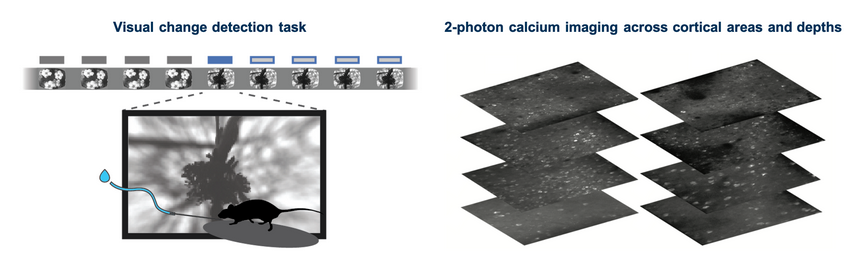

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

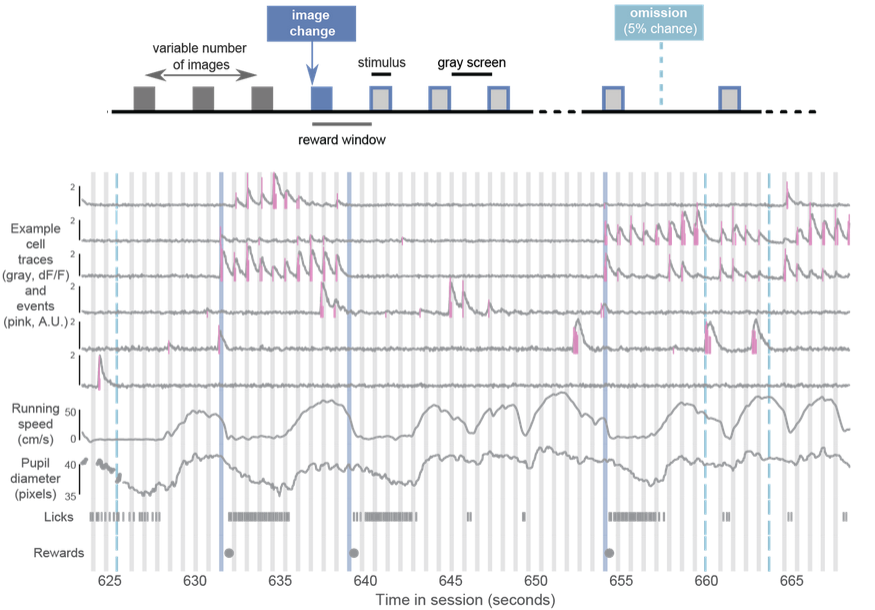

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [9]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

In [10]:
import utils as U

U.extract_and_save_metadata()

2025-07-15 16:40:29,932 - INFO - Output will be saved to: ./output/metadata_summary.json
2025-07-15 16:40:29,933 - INFO - --- Extracting Metadata ---
2025-07-15 16:40:30,029 - INFO - --- Saving collected metadata to metadata_summary.json ---
2025-07-15 16:40:30,030 - INFO - Successfully saved metadata.
2025-07-15 16:40:30,031 - INFO - 
--- Checking for dummy files to clean up ---
2025-07-15 16:40:30,032 - INFO - 
--- Metadata extraction and saving completed ---


'./output/metadata_summary.json'

# Phase 1: Setup, Data Understanding & Preprocessing (Foundation)


2025-07-15 16:43:00,864 - INFO - 
--- Running Visualization Examples ---
2025-07-15 16:43:00,872 - INFO - Attempting to visualize maximum activity projection.


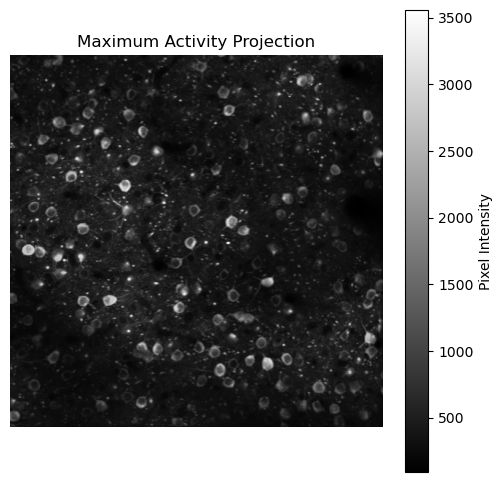

2025-07-15 16:43:01,148 - INFO - Attempting to visualize stimulus frames.
2025-07-15 16:43:01,149 - INFO - Total stimulus frames available: 9000
2025-07-15 16:43:01,150 - INFO - Individual stimulus frame shape: 16x28


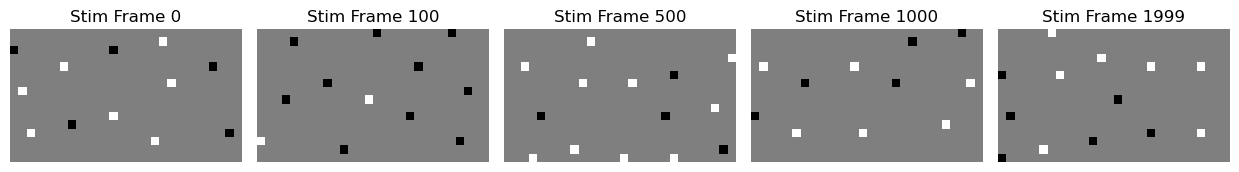

2025-07-15 16:43:01,435 - INFO - Attempting to visualize stimulus frames.
2025-07-15 16:43:01,436 - INFO - Total stimulus frames available: 9000
2025-07-15 16:43:01,437 - INFO - Individual stimulus frame shape: 16x28
2025-07-15 16:43:01,702 - INFO - Stimulus frames plot saved to ./output/sample_stim_frames.png
2025-07-15 16:43:01,703 - INFO - Attempting to visualize maximum activity projection.
2025-07-15 16:43:02,587 - INFO - Maximum projection plot saved to ./output/sample_max_projection.png


In [14]:
import importlib
import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# 2. Call the visualization functions
logging.info("\n--- Running Visualization Examples ---")
importlib.reload(U)

# Example 1: Plot max projection and show it on screen
U.plot_max_projection(data)

# Example 2: Plot specific stimulus frames and show on screen
U.plot_stim_frames(data, indices_to_display=[0, 100, 500, 1000, 1999])

# Example 3: Plot random stimulus frames and save to a file
U.plot_stim_frames(data, num_frames=4, save_path="./output/sample_stim_frames.png")

# Example 4: Plot max projection and save to a file
U.plot_max_projection(data, save_path="./output/sample_max_projection.png")

# Understanding the Images:

## Maximum Activity Projection:

This image represents the overall field of view during the recording. It's often used 
as a background to overlay neuron locations (ROIs) or receptive field centers. The bright spots usually 
indicate areas with active neurons.

## Stimulus Frames: 

These are the individual `16x28` pixel images shown to the mouse as part of the 
locally sparse noise stimulus. Each pixel will have a specific intensity. 

You'll use these exact patterns to correlate with neural activity and determine the receptive fields.

In [60]:
data

{'t': array([   9.33015,    9.36332,    9.39649, ..., 3524.51876, 3524.55193,
        3524.5851 ]),
 'dff': array([[0.18523291, 0.22521365, 0.15662627, ..., 0.12980926, 0.22385855,
         0.20101474],
        [0.16234137, 0.19563715, 0.09819604, ..., 0.05814588, 0.16424954,
         0.13883777],
        [0.25420046, 0.09492928, 0.08878411, ..., 0.01382907, 0.07531496,
         0.10702039],
        ...,
        [0.2853903 , 0.11622677, 0.23714365, ..., 0.14905313, 0.18771276,
         0.05753416],
        [0.28776762, 0.21889563, 0.28706336, ..., 0.01415547, 0.01443406,
         0.09131528],
        [0.25064704, 0.08025383, 0.19734518, ..., 0.32296655, 0.3207836 ,
         0.45805585]], dtype=float32),
 'stim_table':       frame   start     end
 0         0     737     744
 1         1     745     752
 2         2     752     759
 3         3     760     767
 4         4     767     774
 ...     ...     ...     ...
 8875   8875  105705  105712
 8876   8876  105712  105719
 8877   8877

In [61]:
data["stim_epoch_table"]

,start,end,stimulus
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742


In [16]:
# %%
# Import necessary packages if not already imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import signal  # For decimate, butter, filtfilt if you put preproc here
import oasis.functions  # For OASIS spike inference

# This assumes your load_data function is already defined and working
# e.g., from the beginning of your Project 02 notebook.
# For demonstration purposes, I'll put a placeholder if you don't have it handy.
try:
    data = load_data()
except NameError:
    print("load_data() not found, please ensure your notebook has it defined.")
    print("Loading directly from dff_data_rf.npz for this example.")
    # Fallback for demonstration if load_data() isn't in context
    data_path = "dff_data_rf"  # Adjust if your data is elsewhere
    data = np.load(os.path.join(data_path, "dff_data_rf.npz"), allow_pickle=True)
    data = dict(data)
    data["stim_table"] = pd.DataFrame(
        data["stim_table"], columns=["frame", "start", "end"]
    )
    data["stim_epoch_table"] = pd.DataFrame(
        data["stim_epoch_table"], columns=["start", "end", "stimulus"]
    )

/Users/aakarsh/opt/anaconda3/envs/tue-summer-2025-oasis/lib/python3.11/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [17]:
# The columns of stim_epoch_table are mislabelled in the original data
# we ensure first column is stimulus the second is start_time and the third is end_time
data["stim_epoch_table"] = data["stim_epoch_table"].rename(
    columns={
        data["stim_epoch_table"].columns[0]: "stimulus",
        data["stim_epoch_table"].columns[1]: "start_time",
        data["stim_epoch_table"].columns[2]: "end_time",
    }
)

In [18]:
data["stim_epoch_table"]  # before fixing column names

,stimulus,start_time,end_time
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742


In [19]:
data["stim_epoch_table"]  # After fixing column names

,stimulus,start_time,end_time
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742


In [20]:
# %%
# --- Begin Phase 1, Task 1.3: Data Filtering for Locally Sparse Noise Epochs ---
# This part filters the data for 'locally sparse noise' only
# 1. Identify relevant stimulus epochs
sparse_noise_epochs = data["stim_epoch_table"][
    data["stim_epoch_table"]["stimulus"] == "locally_sparse_noise"
].copy()  # .copy() is good practice to avoid SettingWithCopyWarning later

print(f"Found {len(sparse_noise_epochs)} sparse noise epochs.")
assert len(sparse_noise_epochs) == 3, "No sparse noise epochs found."

Found 3 sparse noise epochs.


In [21]:
# --- FIX START ---
# Convert 'start' and 'end' columns to numeric (float) and to seconds
# Assuming they are currently in milliseconds based on typical neuroscience data
sparse_noise_epochs["start_s"] = (
    pd.to_numeric(sparse_noise_epochs["start_time"]) / 1000.0
)
sparse_noise_epochs["end_s"] = pd.to_numeric(sparse_noise_epochs["end_time"]) / 1000.0
# --- FIX END ---

In [22]:
len(sparse_noise_epochs) == 3

True

In [23]:
# Initialize masks for filtering.
# This mask will be used to select the relevant time points from data["t"], data["dff"], etc.
time_mask = np.full(data["t"].shape, False, dtype=bool)

# Create a boolean mask for time points within sparse noise epochs
# Now, row["start_s"] and row["end_s"] are floats in seconds, compatible with data["t"]
for _, row in sparse_noise_epochs.iterrows():
    start_time_s = row["start_s"]
    end_time_s = row["end_s"]
    time_mask = time_mask | ((data["t"] >= start_time_s) & (data["t"] < end_time_s))

# Apply the time mask to the main time-series data
t_filtered = data["t"][time_mask]
dff_filtered = data["dff"][:, time_mask]
running_speed_filtered = data["running_speed"][:, time_mask]

In [24]:
t_filtered.shape, dff_filtered.shape, running_speed_filtered.shape

((1760,), (189, 1760), (2, 1760))

In [25]:
# --- Handle stim_table and stim.npy filtering ---
# This part is more complex as stim_table links to stim frames, not directly to t.
# We need to find which stimulus frames were presented *during* the filtered time epochs.

# Get the min and max time of the *filtered* calcium recording
min_t_filtered = t_filtered.min()
max_t_filtered = t_filtered.max()

# Convert stim_table's 'start' and 'end' to seconds for comparison
data["stim_table"]["start_s"] = data["stim_table"]["start"] / 1000.0
data["stim_table"]["end_s"] = data["stim_table"]["end"] / 1000.0

# Filter stim_table to include only frames whose presentation times
# overlap with the filtered calcium recording time window.
# We'll use the 'frame' column to index into the 'stim' array.
stim_table_filtered_df = data["stim_table"][
    (data["stim_table"]["start_s"] >= min_t_filtered)
    & (data["stim_table"]["start_s"] < max_t_filtered)  # Use start_s for consistency
].copy()

# Now, use the 'frame' indices from the filtered stim_table to get the actual stimulus frames
# Ensure you don't go out of bounds of the original 'stim' array.
# The 'frame' column in stim_table corresponds to the index in the stim.npy array.
unique_filtered_frames_indices = stim_table_filtered_df["frame"].unique()
# Ensure indices are within bounds of data['stim']
valid_frame_indices = unique_filtered_frames_indices[
    (unique_filtered_frames_indices >= 0)
    & (unique_filtered_frames_indices < data["stim"].shape[0])
]
# Select the actual stimulus frames
stim_filtered = data["stim"][valid_frame_indices]

# Update stim_table_filtered_df to only include entries for frames that were actually selected
stim_table_filtered_df = (
    stim_table_filtered_df[stim_table_filtered_df["frame"].isin(valid_frame_indices)]
    .sort_values(by="start_s")
    .reset_index(drop=True)
)  # Sort by time and reset index

# --- End Phase 1, Task 1.3 ---

print(f"Original dff shape: {data['dff'].shape}")
print(f"Filtered dff shape: {dff_filtered.shape}")
print(f"Original t shape: {data['t'].shape}")
print(f"Filtered t shape: {t_filtered.shape}")
print(f"Original running_speed shape: {data['running_speed'].shape}")
print(f"Filtered running_speed shape: {running_speed_filtered.shape}")
print(f"Filtered stim_table_df shape: {stim_table_filtered_df.shape}")
print(f"Filtered stim shape: {stim_filtered.shape}")

Original dff shape: (189, 105968)
Filtered dff shape: (189, 1760)
Original t shape: (105968,)
Filtered t shape: (1760,)
Original running_speed shape: (2, 105968)
Filtered running_speed shape: (2, 1760)
Filtered stim_table_df shape: (7739, 5)
Filtered stim shape: (7739, 16, 28)


2025-07-15 17:01:58,160 - INFO - Plotting preprocessing comparison for neuron 10.


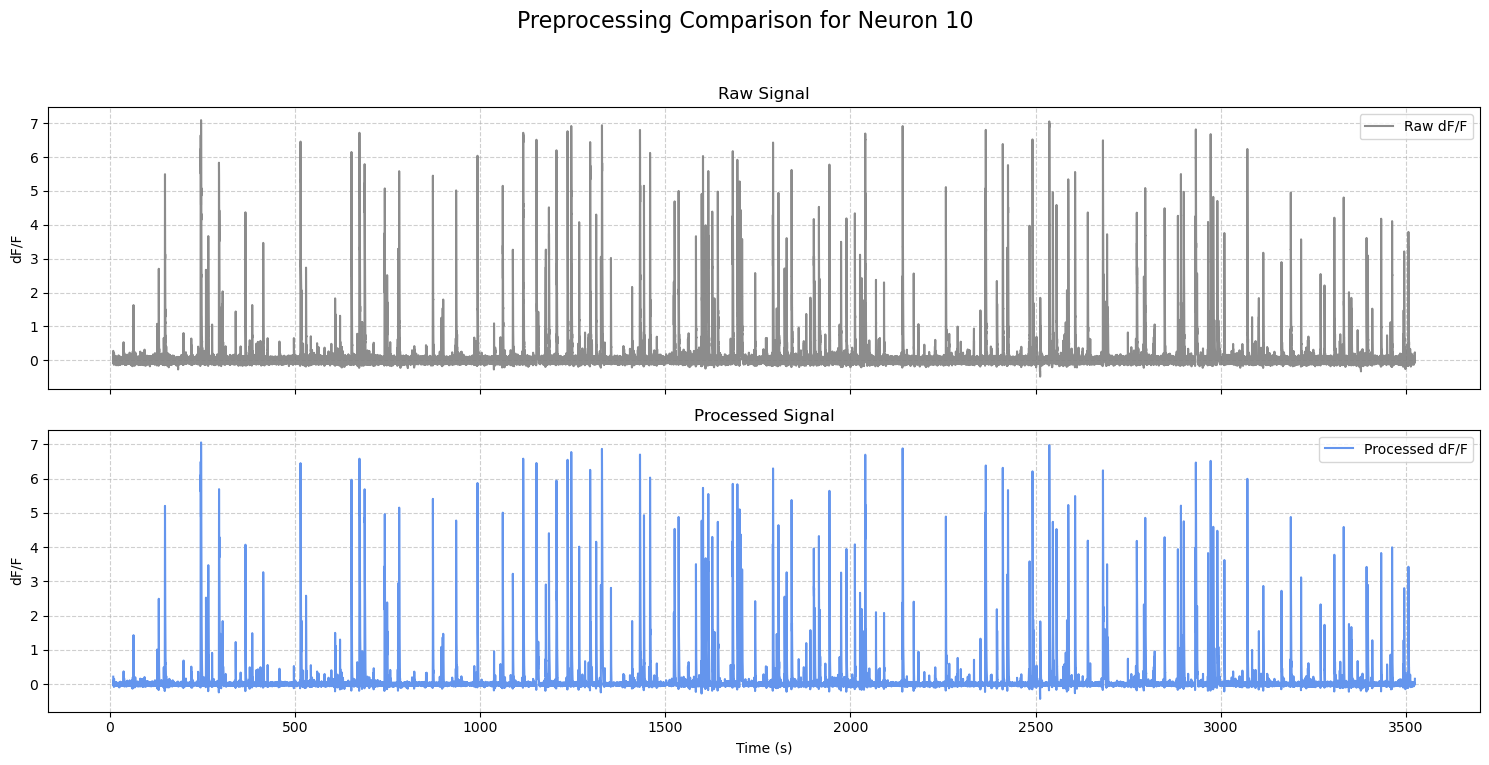

In [29]:
importlib.reload(U)
# Select a neuron to plot
neuron_to_plot = 10
raw_signal = data["dff"][neuron_to_plot]
# Create a dummy "processed" signal for demonstration (e.g., by smoothing)
from scipy.signal import savgol_filter

processed_signal = savgol_filter(raw_signal, window_length=11, polyorder=2)
time_signal = data["t"]

U.plot_preprocessing_comparison(
    raw_signal, processed_signal, time_signal, neuron_id=neuron_to_plot
)